In [ ]:
import networkx as nx
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Step 1: Load the edges (relationships) from the deezer_edges.csv file
edges_file = '/content/drive/MyDrive/deezer_europe/deezer_europe_edges.csv'
edges_df = pd.read_csv(edges_file)
edges_df.head()



,node_1,node_2
0,0,14270
1,0,16976
2,0,12029
3,0,3001
4,0,14581


In [ ]:
import matplotlib.pyplot as plt
# Function to visualize the graph
def visualize_graph(G, title="Graph Visualization", max_nodes=100):

    plt.figure(figsize=(10, 10))
    subgraph = G if G.number_of_nodes() <= max_nodes else G.subgraph(list(G.nodes)[:max_nodes])
    pos = nx.spring_layout(subgraph)  # Layout for visualization
    nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(title)
    plt.show()

In [ ]:
G = nx.Graph()

G.add_edges_from(edges_df.values)


In [ ]:
target_file = '/content/drive/MyDrive/deezer_europe/deezer_europe_target.csv'
target_df = pd.read_csv(target_file)
target_df.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [ ]:
import json
features_file = '/content/drive/MyDrive/deezer_europe/deezer_europe_features.json'

with open(features_file) as f:
    node_features = json.load(f)

In [ ]:
# Ensure that the nodes in the graph have features (optional, if features are necessary for community detection)
for node, features in node_features.items():
    if G.has_node(int(node)):
        G.nodes[int(node)]['features'] = features

In [ ]:
for _, row in target_df.iterrows():
    node_id = row['id']
    gender_label = row['target']  # Assuming 0 = Male, 1 = Female (or vice versa)
    if G.has_node(node_id):
        G.nodes[node_id]['label'] = gender_label


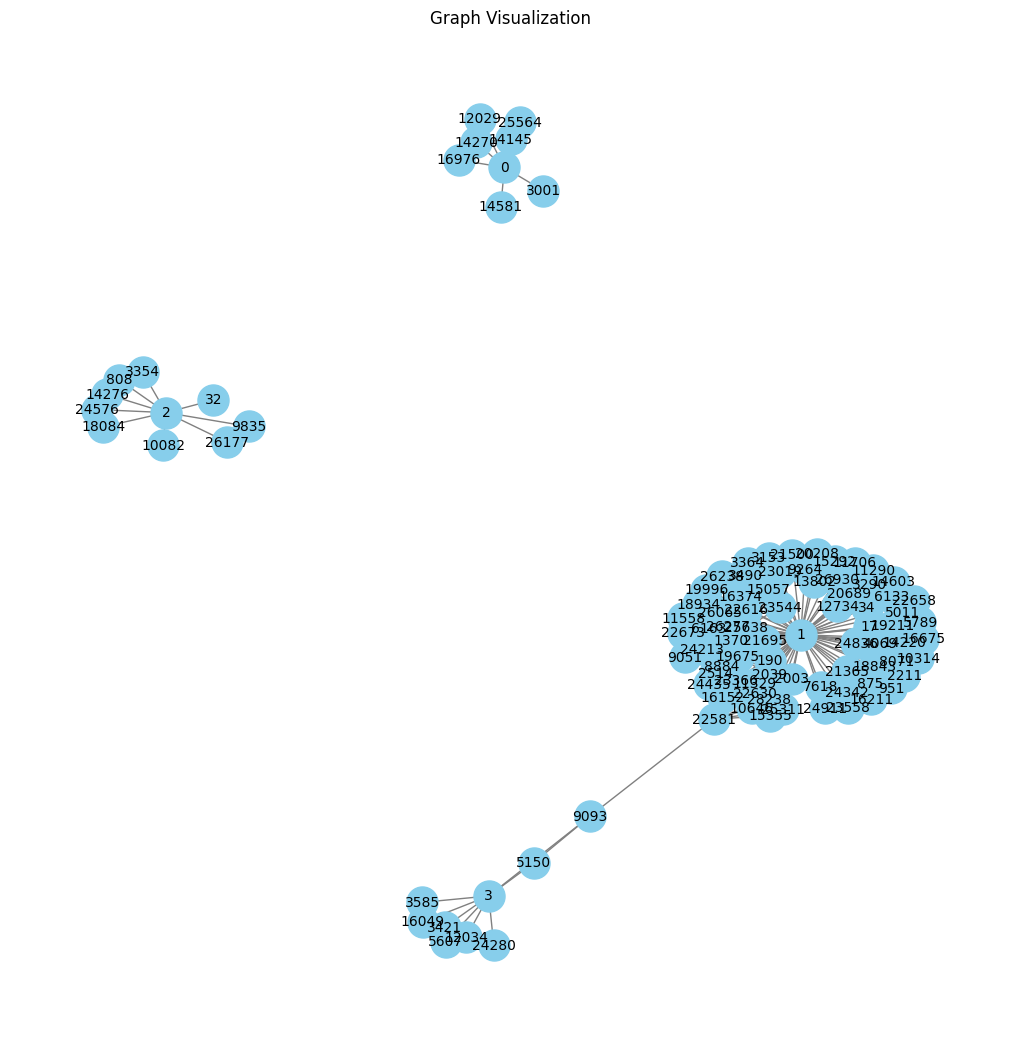

In [ ]:
visualize_graph(G)

In [ ]:
import networkx as nx
from sklearn.model_selection import train_test_split
import random
import itertools
import numpy as np

# Step 1: Load the Graph
G = nx.read_edgelist('/content/drive/MyDrive/deezer_europe/deezer_europe_edges.csv', delimiter=',', nodetype=str, create_using=nx.Graph())

# Step 2: Get all edges
edges = list(G.edges())

# Step 3: Sample non-edges efficiently using dynamic sampling
def sample_non_edges(G, num_samples):
    """Dynamically sample non-edges without generating all non-edges."""
    non_edges = set()
    while len(non_edges) < num_samples:
        u, v = random.sample(G.nodes(), 2)
        if not G.has_edge(u, v):
            non_edges.add((u, v))
    return list(non_edges)

# Sample a small subset of non-edges
num_non_edges_to_sample = len(edges)  # Equal number of non-edges as edges
non_edges = sample_non_edges(G, num_non_edges_to_sample)

# Step 4: Split edges and non-edges into train/test sets
train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)
train_non_edges, test_non_edges = train_test_split(non_edges, test_size=0.2, random_state=42)

# Step 5: Remove test edges from the graph to prepare the training graph
G_train = G.copy()
G_train.remove_edges_from(test_edges)

# Step 6: Batch Processing for Memory Efficiency
batch_size = 1000

def process_in_batches(edges_list, non_edges_list, batch_size):
    """Process edges and non-edges in smaller batches."""
    for i in range(0, len(edges_list), batch_size):
        edge_batch = edges_list[i:i + batch_size]
        non_edge_batch = non_edges_list[i:i + batch_size]
        yield edge_batch, non_edge_batch

# Example batch processing
for edge_batch, non_edge_batch in process_in_batches(train_edges, train_non_edges, batch_size):
    # Your processing logic here for each batch
    print(f"Processing batch of {len(edge_batch)} edges and {len(non_edge_batch)} non-edges")

# Step 7: Confirm batch processing without crashing
print(f"Total number of train edges: {len(train_edges)}")
print(f"Total number of train non-edges: {len(train_non_edges)}")


<ipython-input-30-28893cf3a5e4>:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u, v = random.sample(G.nodes(), 2)


Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges
Processing batch of 1000 edges and 1000 non-edges


In [ ]:
# Step 4: Feature Engineering for Links (use common neighbors, Jaccard similarity, Adamic-Adar, etc.)
def compute_link_features(G, edges):
    features = []
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        jaccard_coeff = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        features.append([common_neighbors, jaccard_coeff, adamic_adar])
    return features

# Step 5: Compute features for train and test edges
train_edge_features = compute_link_features(G_train, train_edges)
train_non_edge_features = compute_link_features(G_train, train_non_edges)

test_edge_features = compute_link_features(G_train, test_edges)
test_non_edge_features = compute_link_features(G_train, test_non_edges)


In [ ]:
import numpy as np

# Step 6: Prepare labels (1 for edges, 0 for non-edges)
train_labels = np.hstack([np.ones(len(train_edges)), np.zeros(len(train_non_edges))])
test_labels = np.hstack([np.ones(len(test_edges)), np.zeros(len(test_non_edges))])

# Combine edge and non-edge features
X_train = np.vstack([train_edge_features, train_non_edge_features])
X_test = np.vstack([test_edge_features, test_non_edge_features])


AUC-ROC Score: 0.713905250328921


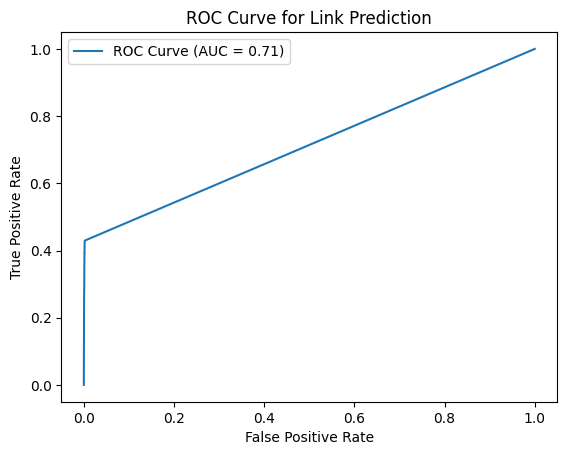

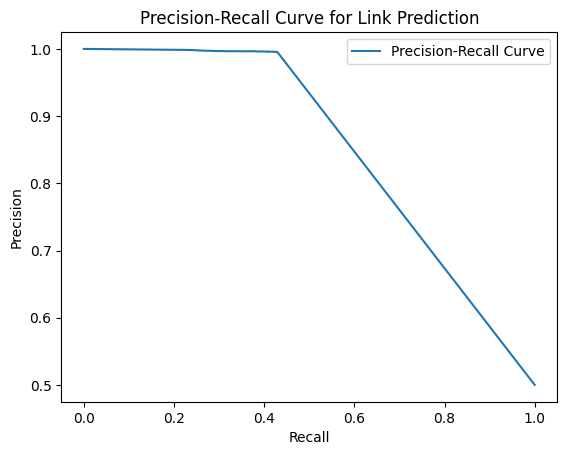

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Step 7: Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=4, min_samples_split=2, random_state=42)
clf.fit(X_train, train_labels)

# Step 8: Evaluate the model
y_pred_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(test_labels, y_pred_proba)

print(f'AUC-ROC Score: {roc_auc}')

# Step 9: Plot the ROC Curve
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Link Prediction")
plt.legend()
plt.show()

# Step 10: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Link Prediction")
plt.legend()
plt.show()


              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78     18551
         1.0       1.00      0.43      0.60     18551

    accuracy                           0.71     37102
   macro avg       0.82      0.71      0.69     37102
weighted avg       0.82      0.71      0.69     37102



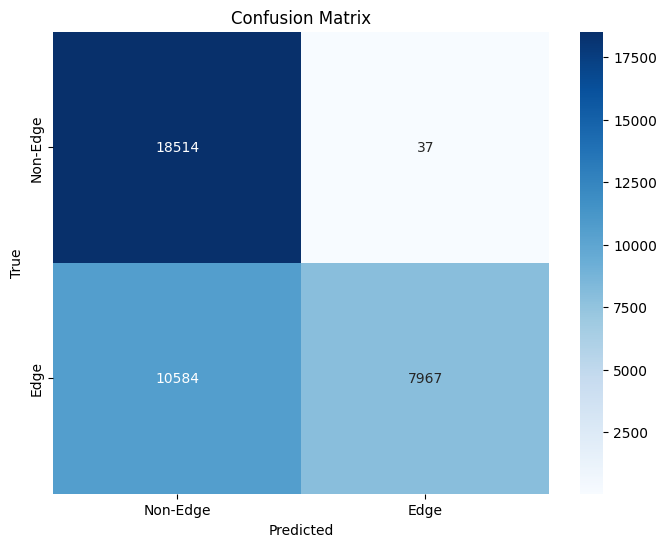

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(test_labels, y_pred))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Edge", "Edge"],
            yticklabels=["Non-Edge", "Edge"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index, preferential_attachment

In [ ]:
# Step 1: Compute graph-based features for train and test edges
def compute_graph_features(G, edges):
    features = []
    for u, v in edges:
        # Common Neighbors
        cn = len(list(nx.common_neighbors(G, u, v)))  # Use nx.common_neighbors instead
        # Jaccard Coefficient
        jc = next(jaccard_coefficient(G, [(u, v)]))[2]
        # Adamic-Adar Index
        aa = next(adamic_adar_index(G, [(u, v)]))[2]
        # Preferential Attachment
        pa = next(preferential_attachment(G, [(u, v)]))[2]
        features.append([cn, jc, aa, pa])
    return features

In [ ]:
# Step 2: Compute features for train and test sets
train_edge_features = compute_graph_features(G_train, train_edges)
train_non_edge_features = compute_graph_features(G_train, train_non_edges) # Compute features for non-edges

test_edge_features = compute_graph_features(G_train, test_edges)
test_non_edge_features = compute_graph_features(G_train, test_non_edges) # Compute features for non-edges


In [ ]:
# Step 3: Scale the features
# Combine edge and non-edge features for scaling
X_train_unscaled = train_edge_features + train_non_edge_features
X_test_unscaled = test_edge_features + test_non_edge_features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

AUC-ROC Score: 0.7980907332428737


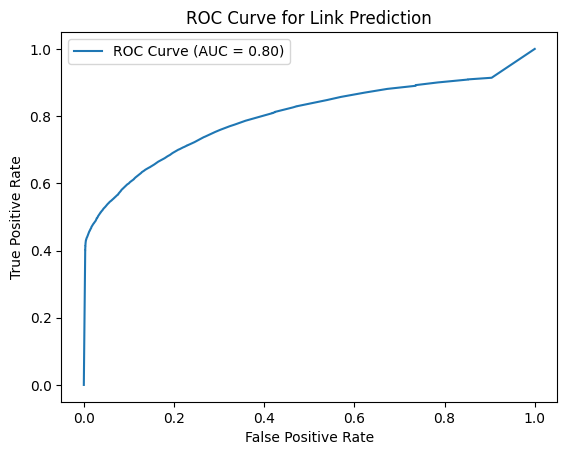

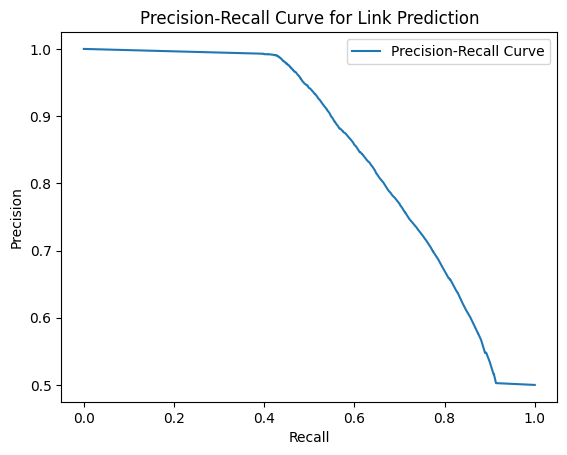

In [ ]:


# Step 4: Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, train_labels)

# Step 5: Evaluate the model
y_pred_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(test_labels, y_pred_proba)
print(f'AUC-ROC Score: {roc_auc}')

# Step 6: Plot the ROC Curve
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Link Prediction")
plt.legend()
plt.show()

# Step 7: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, y_pred_proba)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Link Prediction")
plt.legend()
plt.show()


              precision    recall  f1-score   support

         0.0       0.72      0.82      0.76     18551
         1.0       0.79      0.68      0.73     18551

    accuracy                           0.75     37102
   macro avg       0.75      0.75      0.75     37102
weighted avg       0.75      0.75      0.75     37102



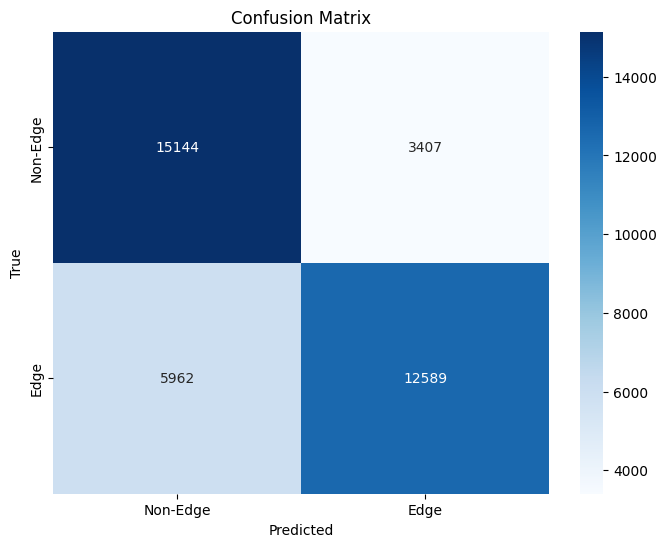

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(test_labels, y_pred))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Edge", "Edge"],
            yticklabels=["Non-Edge", "Edge"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Step 2: Perform grid search
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, train_labels)




Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [ ]:
# Step 3: Get the best parameters and evaluate
best_clf = grid_search.best_estimator_
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(test_labels, y_pred_proba)

print(f'AUC-ROC Score after tuning: {roc_auc}')

AUC-ROC Score after tuning: 0.7990642044709059


              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76     18551
         1.0       0.79      0.68      0.73     18551

    accuracy                           0.75     37102
   macro avg       0.75      0.75      0.75     37102
weighted avg       0.75      0.75      0.75     37102



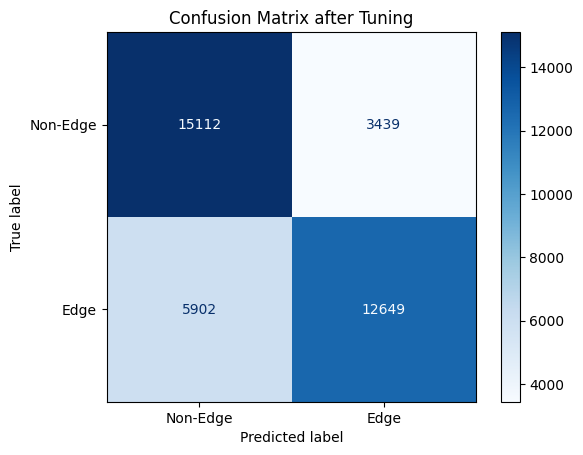

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_clf.predict(X_test)

# Classification Report
print(classification_report(test_labels, y_pred))

# Confusion Matrix and Display
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Edge', 'Edge'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix after Tuning")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
roc_auc_scores = cross_val_score(best_clf, X_train, train_labels, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC-ROC Scores: {roc_auc_scores}")
print(f"Mean AUC-ROC Score: {np.mean(roc_auc_scores)}")


Cross-Validation AUC-ROC Scores: [0.88095843 0.87751317 0.88123184 0.87965958 0.87477012]
Mean AUC-ROC Score: 0.8788266292862581


In [ ]:


# Get predicted probabilities for the positive class (link exists)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

threshold = 0.5

# Iterate through the test data and generate links based on predicted probabilities
predicted_links = []
for i in range(len(X_test)):
  if y_pred_proba[i] >= threshold:  # If the probability is above the threshold, predict a link
    if i < len(test_edges):  # If it's a test edge
      u, v = test_edges[i]
      predicted_links.append((u, v))
    else:  # If it's a test non-edge
      u, v = test_non_edges[i - len(test_edges)]
      predicted_links.append((u, v))

print(f"Predicted links: {predicted_links}")

Predicted links: [('14033', '20833'), ('26409', '9854'), ('20861', '8996'), ('27669', '5060'), ('20553', '17507'), ('2401', '4799'), ('6843', '4307'), ('10998', '16162'), ('1579', '12506'), ('17892', '16195'), ('11295', '15064'), ('20081', '6370'), ('4291', '18873'), ('17542', '7695'), ('23455', '5309'), ('25555', '1933'), ('4823', '22106'), ('27514', '3326'), ('23719', '22607'), ('20950', '12449'), ('3961', '18736'), ('23400', '8677'), ('5344', '19731'), ('14997', '22200'), ('25901', '1622'), ('3871', '4326'), ('23631', '11430'), ('27129', '26668'), ('478', '15650'), ('9940', '9528'), ('17035', '4541'), ('24764', '16349'), ('5852', '25708'), ('23459', '25096'), ('12994', '7139'), ('872', '7878'), ('3845', '6458'), ('439', '5340'), ('23553', '16963'), ('2518', '12855'), ('11045', '1253'), ('10934', '14096'), ('15271', '19180'), ('21126', '24764'), ('5876', '10937'), ('416', '15670'), ('5473', '18468'), ('19348', '17398'), ('27179', '15110'), ('17905', '27274'), ('21873', '11673'), ('41

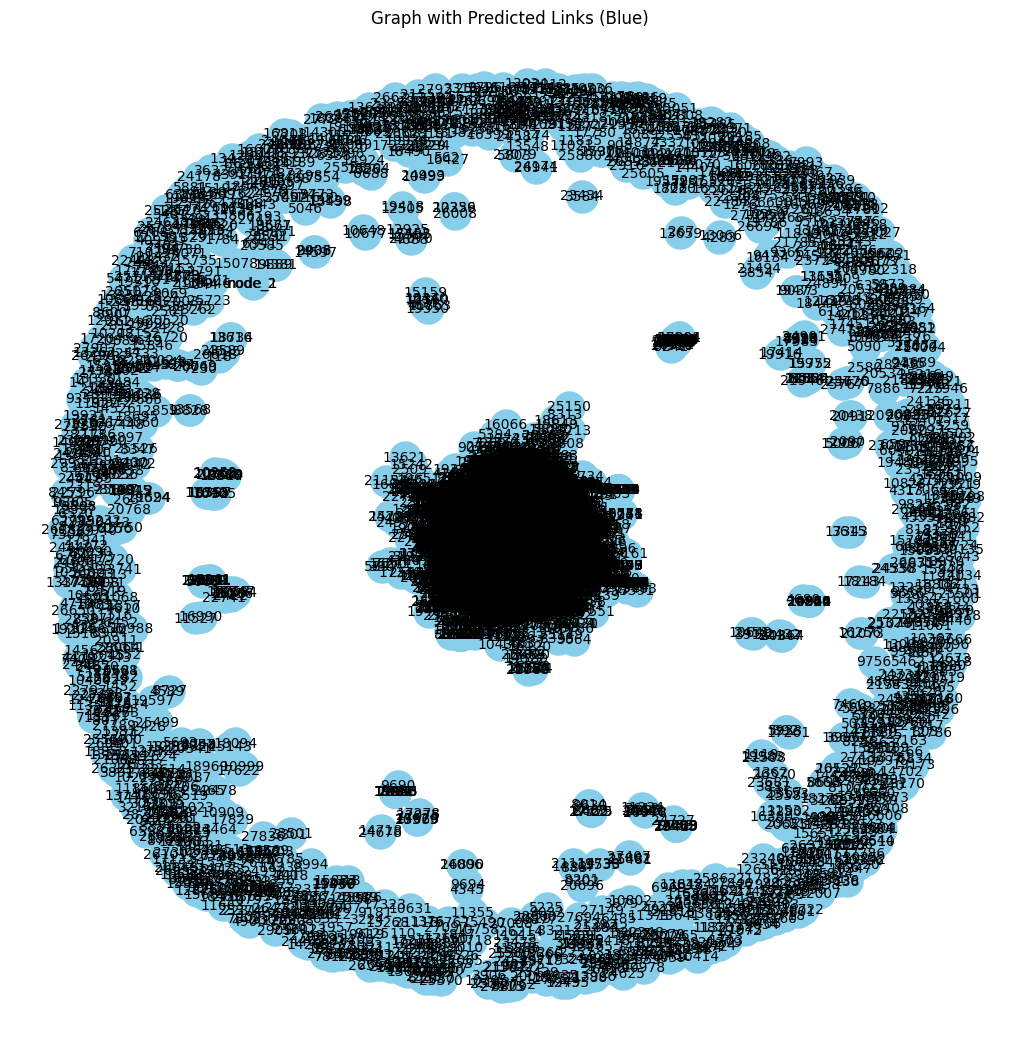

In [ ]:


# Visualize the predicted links on the graph
G_predicted = G_train.copy()  # Start with the training graph
G_predicted.add_edges_from(predicted_links)

# Highlight the predicted links
edge_colors = ['blue' if edge in predicted_links else 'gray' for edge in G_predicted.edges()]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_predicted)  # Layout for visualization
nx.draw(G_predicted, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, node_size=500, font_size=10)
plt.title("Graph with Predicted Links (Blue)")
plt.show()

